Using the saved light curves we evaluate for each a log-likelihood (posterior) space for various priors, and marginalize to find posterior pdf for each hyperparameter. We save for each light curve the full posterior logL space to enable future investigation of shape of logL . 

We use  the same saved light curves as for DRW_Chelsea_Celerite_test.ipynb

In [2]:
## Imports
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize

import matplotlib.pyplot as plt
from matplotlib import rcParams      
rcParams['ytick.labelsize'] = 15
rcParams['xtick.labelsize'] = 15
rcParams['axes.labelsize'] = 20
rcParams['axes.linewidth'] = 2
rcParams['font.size'] = 15
rcParams['axes.titlesize'] = 18

import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column

In [ ]:
# Make a directory for today :
# Make a todays dir to save the figure ...
import os 
import datetime

outDir = os.path.join(os.getcwd()[:-len('code')],'data_products/DRW_ZI_LC_full_logL',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)



## Read-in light curves 

Input properties for each of the 1000 light curves  : 

  $\tau_{in} = 100 $ days
   
  $\sigma_{in} = 0.2  $ mag

  $SF_{\infty} = 0.2*\sqrt{2} = 0.2828$ mag

length = $l= 20 \tau$

dt = 5 days 

random sampling  from a uniform distribution 

yerr = 0.001  mag 

400 points 

In [5]:
# Fitting  : each light curve is fit with various settings : 

sigma_in = 0.2
tau_in = 100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))

DirIn = '../raw_data/DRWtestCeleriteZI/'
files = os.listdir(DirIn)


In [19]:
# Make a grid for logL...
step  = 0.01
start = 0.4
stop = 2.5
N = int((stop - start) /step)
grid = np.linspace(start, stop, N)

sigma_grid = grid * sigma_in
tau_grid = grid * tau_in

log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)




210

In [ ]:


# initialize dictionaries to store the results  
results = {}
# define which priors we would like to try ... 
priors = ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']
for prior in  priors:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float)
                     }

for k in range(len(files)) :
    # read in saved light curves
    lc = Table.read(DirIn +files[k], format='ascii', 
                    names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']

    print('Light curve %s : %d / %d'%(files[k], k, len(files)))
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    loglike_dic = {}
    for prior in priors:  
        # loop over the likelihood space .... 
        print('Calculating the negloglike grid for %s prior'%prior)
        loglike = np.zeros([N,N], dtype=float)
        for i in range(len(log_a_grid)):
            for j in range(len(log_c_grid)):
                params = [log_a_grid[i],log_c_grid[j]]

                if prior is 'flat' : 
                    def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        return -gp.log_likelihood(y)
                    
                if prior is 'p1' : # sigma*tau 
                    def neg_log_like(params,y,gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y) - (log_a / 2.0) + log_c

                if prior is 'p2' : # sigma_hat * tau 
                     def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )

                if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
                    def neg_log_like(params,y,gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y) + (log_a / 2.0) - log_c


                if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
                    def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

                # evaluate the neg_log_like on a grid of sigma, tau ...     
                loglike[i,j] = neg_log_like(params,y,gp)

        # store all logL spaces for that prior ... 
        loglike_dic[prior] = loglike

    # save in  a file ...
    fname = files[k][:-4]+'_logL.npy'
    np.save(outDir + fname, loglike_dic)
    print('Saved logL dic as %s'%fname)


Light curve DRWtestCeleriteZI_LC513.dat : 0 / 1000
Calculating the negloglike grid for flat prior
Calculating the negloglike grid for p1 prior
Calculating the negloglike grid for p2 prior
Calculating the negloglike grid for Jeff1 prior
Calculating the negloglike grid for Jeff2 prior
Saved logL dic as DRWtestCeleriteZI_LC513_logL.npy
Light curve DRWtestCeleriteZI_LC275.dat : 1 / 1000
Calculating the negloglike grid for flat prior
Calculating the negloglike grid for p1 prior
Calculating the negloglike grid for p2 prior
Calculating the negloglike grid for Jeff1 prior
Calculating the negloglike grid for Jeff2 prior
Saved logL dic as DRWtestCeleriteZI_LC275_logL.npy
Light curve DRWtestCeleriteZI_LC34.dat : 2 / 1000
Calculating the negloglike grid for flat prior
Calculating the negloglike grid for p1 prior
Calculating the negloglike grid for p2 prior
Calculating the negloglike grid for Jeff1 prior
Calculating the negloglike grid for Jeff2 prior
Saved logL dic as DRWtestCeleriteZI_LC34_logL.n

In [91]:
# test reading in the logL space ...

fname = os.listdir(outDir)[0]
logL_dic = np.load(outDir+fname).item()

In [103]:
outDir

'/Users/chris/GradResearch/DRW_Celerite/data_products/DRW_ZI_LC_full_logL/2017-11-13/'

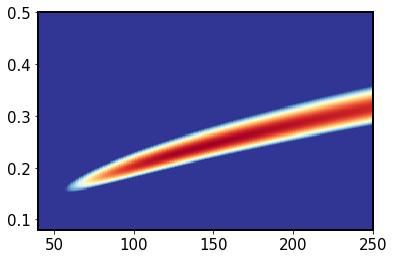

In [98]:
%matplotlib inline 
x = logL_dic['p2']
shift = x-min(np.ravel(x))
norm = np.sum(shift)
z = shift / norm
fig,ax = plt.subplots(1,1)
ax.imshow(z, extent=(tau_grid[0], tau_grid[-1], sigma_grid[0], sigma_grid[-1]),
         cmap=plt.cm.get_cmap('RdYlBu'),vmax=0.000001,
        aspect='auto', origin='lower')

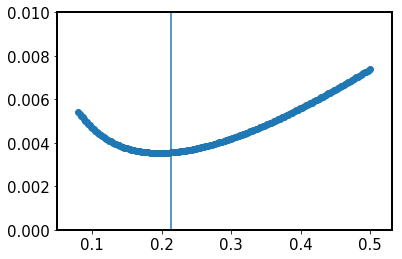

In [61]:
# print a marginalized version ...
plt.ylim(0,1e-2)
plt.scatter(sigma_grid, np.sum(z, axis=0))
sigma =  results['Jeff2']['sigma_fit'][0]
plt.axvline(sigma)

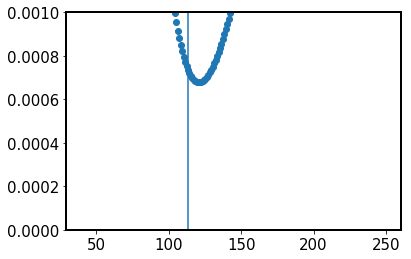

In [73]:
plt.scatter(tau_grid, np.sum(z, axis=1))
plt.ylim(0,1e-3)
tau = results['Jeff2']['tau_fit'][0]
plt.axvline(tau)

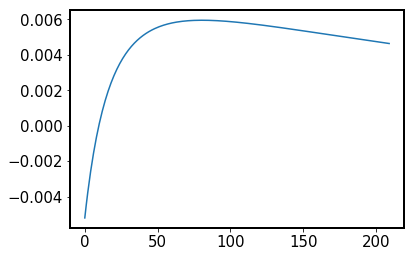

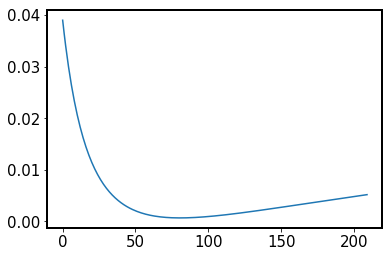

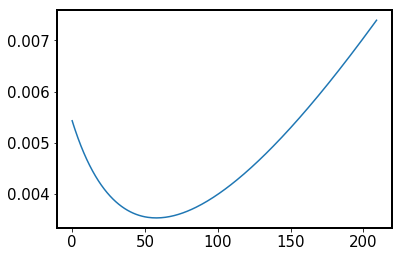

In [77]:
p_sigma = np.sum(z, axis=0)
plt.plot(p_sigma)

In [81]:
# find expectation value : 
dsigma = sigma_grid[1] - sigma_grid[0]
mean_sigma = np.sum(sigma_grid * p_sigma * dsigma)
#mean_tau

In [83]:
mean_sigma

0.00062876641861369699

In [29]:
fname = 'ZI_fits_results_11-07-17.npy'
simDir = '../data_products/Fig_Celerite_ZI_LC_fits/2017-11-08/'
results = np.load(simDir+fname).item()


{'Jeff1': {'s_loga': array([ 0.27699086,  0.23176207,  0.27081422,  0.24464726,  0.23088132,
          0.2511194 ,  0.20161518,  0.25021784,  0.2683708 ,  0.27313308,
          0.23157982,  0.24731491,  0.26639818,  0.22468181,  0.28462851,
          0.24540067,  0.21383519,  0.22538722,  0.22749483,  0.2684687 ,
          0.2735269 ,  0.2395399 ,  0.23770825,  0.31476661,  0.2666191 ,
          0.24930612,  0.2653164 ,  0.25035388,  0.25362062,  0.25797819,
          0.26021059,  0.28150792,  0.23546013,  0.2123918 ,  0.25286829,
          0.23954643,  0.25376058,  0.19883118,  0.23804501,  0.27972271,
          0.23064552,  0.24287412,  0.26001239,  0.24389259,  0.2486893 ,
          0.20462146,  0.23645554,  0.28527523,  0.26410278,  0.21710512,
          0.25299941,  0.23248719,  0.23137289,  0.24882465,  0.27766591,
          0.27852217,  0.25736359,  0.2512399 ,  0.23095918,  0.21794672,
          0.23642757,  0.30621422,  0.26047583,  0.20547549,  0.2458717 ,
          0.2701670

113.09229583828349

In [34]:
files[0]

'DRWtestCeleriteZI_LC513.dat'

In [36]:
#k

# what I pasted in magneto...

In [ ]:
import numpy as np 
import os
import datetime
from itertools import product
from scipy.optimize import minimize
import celerite
from celerite import terms
from astropy.table import Table
from astropy.table import vstack
from astropy.table import Column
import os 
import datetime

outDir = os.path.join(os.getcwd(),'logL',
                      datetime.datetime.now().strftime('%Y-%m-%d')+ '/')
if not os.path.exists(outDir): os.system('mkdir %s' % outDir)
print('We will save this figure in  %s'%outDir)

DirIn = 'DRWtestCeleriteZI/'
files = os.listdir(DirIn)

# Fitting  : each light curve is fit with various settings : 

sigma_in = 0.2
tau_in = 100
kernel = terms.RealTerm(log_a = 2 * np.log(sigma_in) , 
                        log_c = np.log(1/tau_in))


# Make a grid for logL...
# in units of tau / tau_in ,     
# sigma / sigma_in 
step  = 0.01
start = 0.4
stop = 2.5
N = int((stop - start) /step)
grid = np.linspace(start, stop, N)

sigma_grid = grid * sigma_in
tau_grid = grid * tau_in

log_a_grid = 2 * np.log(sigma_grid)
log_c_grid = np.log(1/tau_grid)


# initialize dictionaries to store the results  
results = {}
# define which priors we would like to try ... 
priors = ['flat', 'p1', 'p2', 'Jeff1', 'Jeff2']
for prior in  priors:
    results[prior] = {'sigma_fit':np.zeros(len(files), dtype=float),
                     'tau_fit':np.zeros(len(files), dtype=float)
                     }

for k in range(len(files)) :
    # read in saved light curves
    lc = Table.read(DirIn +files[k], format='ascii', 
                    names=['time', 'mag', 'err'] )    
    t,y,yerr = lc['time'], lc['mag'], lc['err']

    print('Light curve %s : %d / %d'%(files[k], k, len(files)))
    # call the model  with a chosen kernel instance 
    gp = celerite.GP(kernel, mean=np.mean(y))
    gp.compute(t, yerr)

    loglike_dic = {}
    for prior in priors:  
        # loop over the likelihood space .... 
        print('Calculating the negloglike grid for %s prior'%prior)
        loglike = np.zeros([N,N], dtype=float)
        for i in range(len(log_a_grid)):
            for j in range(len(log_c_grid)):
                params = [log_a_grid[i],log_c_grid[j]]

                if prior is 'flat' : 
                    def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        return -gp.log_likelihood(y)
                    
                if prior is 'p1' : # sigma*tau 
                    def neg_log_like(params,y,gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y) - (log_a / 2.0) + log_c

                if prior is 'p2' : # sigma_hat * tau 
                     def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y)  +0.5* (-np.log(2) + log_c - log_a  )

                if prior is 'Jeff1' : # (1/sigma) * (1/tau) 
                    def neg_log_like(params,y,gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y) + (log_a / 2.0) - log_c


                if prior is 'Jeff2' : # (1/sigma_hat) * (1/tau) 
                    def neg_log_like(params, y, gp):
                        gp.set_parameter_vector(params)
                        log_a = params[0]
                        log_c = params[1]
                        return -gp.log_likelihood(y)  +0.5* (np.log(2) - log_c + log_a  )

                # evaluate the neg_log_like on a grid of sigma, tau ...     
                loglike[i,j] = neg_log_like(params,y,gp)

        # store all logL spaces for that prior ... 
        loglike_dic[prior] = loglike

    # save in  a file ...
    fname = files[k][:-4]+'_logL.npy'
    np.save(outDir + fname, loglike_dic)
    print('Saved logL dic as %s'%fname)



